In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation
%matplotlib ipympl
import numpy as np
import pandas as pd
import pims

from scipy.spatial import KDTree, cKDTree
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

import time
import joblib
from tqdm import tqdm
import trackpy as tp
from numba import njit, prange

from yupi import Trajectory
import yupi.graphics as yg
import yupi.stats as ys

from utility import get_imsd, get_imsd_windowed, get_emsd, get_emsd_windowed, fit_hist, MB_2D,\
                    normal_distr, lorentzian_distr, get_trajs, speed_windowed, theta_windowed, \
                    get_smooth_trajs, get_velocities

show_verb = False
run_windowed_analysis = True
plot_verb = True
animated_plot_verb = True
save_verb = True
run_analysis_verb = True

msd_run = False
speed_run = False
turn_run = False
autocorr_run = True
rdf_run = False

In [2]:
def get_velocities(trajList):
    v = np.zeros((len(trajList), 2, len(trajList[0])), dtype=np.float64)
    for i in range(len(trajList)):
        v[i] = np.array(trajList[i].v).T
    return v

# Power Law fit
def powerLaw(x, a, k):
    return a*x**k

def powerLawFit(f, x, nDrops, yerr):
    if nDrops == 1:
        ret = np.zeros((2, 2))
        ret[0], pcov = curve_fit(powerLaw, x, f, p0 = [1., 1.])
        ret[1] = np.sqrt(np.diag(pcov))
        fit = ret[0, 0] * x**ret[0, 1]
    else:
        fit = np.zeros((nDrops, f.shape[0])) # np.zeros(f.shape).T
        ret = np.zeros((nDrops, 2, 2))
        for i in range(nDrops):
            if yerr is None:
                ret[i, 0], pcov = curve_fit(powerLaw, x, f[i], p0 = [1., 1.])
            else:
                ret[i, 0], pcov = curve_fit(powerLaw, x, f[i], p0 = [1., 1.], sigma = yerr)
            ret[i, 1] = np.sqrt(np.diag(pcov))
            fit[i] = ret[i, 0, 0] * x**ret[i, 0, 1]
    return fit, ret 


def get_imsd(trajs, pxDimension, fps, maxLagtime, nDrops):
    imsd = tp.imsd(trajs, mpp = pxDimension, fps = fps, max_lagtime = maxLagtime)
    # fit the diffusive region of the MSD --> 1s onwards
    fit, pw_exp = powerLawFit(imsd[1:], imsd[1:].index, nDrops, None)
    return imsd, fit, pw_exp


def get_emsd(imsd, x, fps, red_mask, nDrops):
    MSD = np.array(imsd)
    MSD_b = [MSD[:, ~red_mask].mean(axis = 1),
                MSD[:, ~red_mask].std(axis = 1)]
    MSD_r = [MSD[:, red_mask].mean(axis = 1),
                MSD[:, red_mask].std(axis = 1)]
    # fit the diffusive region of the MSD
    fit_b, pw_exp_b = powerLawFit(MSD_b[0][fps-1:], x, 1, MSD_b[1][fps-1:])
    fit_r, pw_exp_r = powerLawFit(MSD_r[0][fps-1:], x, 1, MSD_r[1][fps-1:])
    results = {"fit_b": fit_b, "pw_exp_b": pw_exp_b, "fit_r": fit_r, "pw_exp_r": pw_exp_r}
    return MSD_b, MSD_r, results


def get_imsd_windowed(nSteps, startFrames, endFrames, trajs, pxDimension, fps, maxLagtime, nDrops):
    MSD_wind = []
    # diffusive region of the MSD
    fit_wind = np.zeros((nSteps, nDrops, maxLagtime - fps+1))
    pw_exp_wind = np.zeros((nSteps, nDrops, 2, 2))
    for i in tqdm(range(nSteps)):
        trajs_wind = trajs.loc[trajs.frame.between(startFrames[i], endFrames[i])]
        temp, fit_wind[i], pw_exp_wind[i], = get_imsd(trajs_wind, pxDimension, fps, maxLagtime, nDrops)
        MSD_wind.append(temp)
    return MSD_wind, fit_wind, pw_exp_wind


def get_emsd_windowed(imsds, x, fps, red_particle_idx, nSteps, maxLagtime):
    EMSD_wind = np.array(imsds)
    EMSD_wind_b = [EMSD_wind[:, :, ~red_mask].mean(axis = 2), 
                    EMSD_wind[:, :, ~red_mask].std(axis = 2)]
    EMSD_wind_r = [EMSD_wind[:, :, red_mask].mean(axis = 2), 
                    EMSD_wind[:, :, red_mask].std(axis = 2)]

    # diffusive region of the MSD
    fit_wind_b = np.zeros((nSteps, maxLagtime-fps+1))
    pw_exp_wind_b = np.zeros((nSteps, 2, 2))
    fit_wind_r = np.zeros((nSteps, maxLagtime-fps+1))
    pw_exp_wind_r = np.zeros((nSteps, 2, 2))
    
    for i in tqdm(range(nSteps)):
        fit_wind_b[i], pw_exp_wind_b[i] = powerLawFit(EMSD_wind_b[0][i, fps-1:], x, 1, EMSD_wind_b[1][i, fps-1:])
        fit_wind_r[i], pw_exp_wind_r[i] = powerLawFit(EMSD_wind_r[0][i, fps-1:], x, 1, EMSD_wind_r[1][i, fps-1:])
    
    results = {"fit_wind_b":fit_wind_b, "pw_exp_wind_b":pw_exp_wind_b, "fit_wind_r":fit_wind_r,\
                            "pw_exp_wind_r":pw_exp_wind_r}

    return EMSD_wind_b, EMSD_wind_r, results


# get trajectories
def get_trajs(nDrops, red_particle_idx, trajs):
    blueTrajs = []
    redTrajs = []
    for i in range(0, nDrops):
        if i in red_particle_idx:
            p = trajs.loc[trajs.particle == i, ["x","y"]]
            redTrajs.append(Trajectory(p.x, p.y, dt = 1/fps, traj_id=i))
        else:
            p = trajs.loc[trajs.particle == i, ["x","y"]]
            blueTrajs.append(Trajectory(p.x, p.y, dt = 1/fps, traj_id=i))
    return blueTrajs, redTrajs


# get speed distributions windowed in time
def speed_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajs, v_step, fps):
    v_blue_wind = []
    v_red_wind = []
    for k in tqdm(range(nSteps)):
        trajs_wind = trajs.loc[trajs.frame.between(startFrames[k], endFrames[k])]
        blueTrajs = []
        redTrajs = []
        for i in range(nDrops):
            if i in red_particle_idx:
                p = trajs_wind.loc[trajs_wind.particle==i, ["x","y"]]
                redTrajs.append(Trajectory(p.x, p.y, dt = 1/fps, traj_id=i))
            else:
                p = trajs_wind.loc[trajs_wind.particle==i, ["x","y"]]
                blueTrajs.append(Trajectory(p.x, p.y, dt = 1/fps, traj_id=i))
        v_blue_wind.append(ys.speed_ensemble(blueTrajs, step=v_step))
        v_red_wind.append(ys.speed_ensemble(redTrajs, step=v_step))
    return v_blue_wind, v_red_wind
    

# get turning angles distributions windowed in time
def theta_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajs, fps):
    theta_blue_wind = []
    theta_red_wind = []
    for k in tqdm(range(nSteps)):
        trajs_wind = trajs.loc[trajs.frame.between(startFrames[k], endFrames[k])]
        blueTrajs = []
        redTrajs = []
        for i in range(nDrops):
            if i in red_particle_idx:
                p = trajs_wind.loc[trajs_wind.particle==i, ["x","y"]]
                redTrajs.append(Trajectory(p.x, p.y, dt = 1/fps, traj_id=i))
            else:
                p = trajs_wind.loc[trajs_wind.particle==i, ["x","y"]]
                blueTrajs.append(Trajectory(p.x, p.y, dt = 1/fps, traj_id=i))
        theta_blue_wind.append(ys.turning_angles_ensemble(blueTrajs, centered= True))
        theta_red_wind.append(ys.turning_angles_ensemble(redTrajs, centered= True))
    return theta_blue_wind, theta_red_wind


# 2D Maxwell-Boltzmann distribution
def MB_2D(v, sigma):
    return v/(sigma**2) * np.exp(-v**2/(2*sigma**2))

# Normal distribution
def normal_distr(x, sigma, mu):
    return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*((x-mu)/sigma)**2)

def lorentzian_distr(x, gamma, x0):
    return 1/np.pi * gamma / ((x-x0)**2 + gamma**2)

# Histogram fit
def fit_hist(y, bins_, distribution, p0_):
    bins_c = bins_[:-1] + np.diff(bins_) / 2
    bin_heights, _ = np.histogram(y, bins = bins_, density = True)
    ret, pcov = curve_fit(distribution, bins_c, bin_heights, p0 = p0_)
    ret_std = np.sqrt(np.diag(pcov))
    return ret, ret_std

def vacf_windowed(trajectories):        
    vacf_b_wind = []
    vacf_b_std_wind = []
    vacf_r_wind = []
    vacf_r_std_wind = []
    
    for k in tqdm(range(nSteps)):
        trajs = trajectories.loc[trajectories.frame.between(startFrames[k], endFrames[k])]
        blueTrajs, redTrajs = get_trajs(nDrops, red_particle_idx, trajs)
        temp = ys.vacf(blueTrajs, time_avg = True, lag = maxLagtime)
        vacf_b_wind.append(temp[0])
        vacf_b_std_wind.append(temp[1])
        temp = ys.vacf(redTrajs, time_avg = True, lag = maxLagtime)
        vacf_r_wind.append(temp[0])
        vacf_r_std_wind.append(temp[1])

    vacf_b_wind = pd.DataFrame(vacf_b_wind)
    vacf_b_std_wind = pd.DataFrame(vacf_b_std_wind)
    vacf_r_wind = pd.DataFrame(vacf_r_wind)
    vacf_r_std_wind = pd.DataFrame(vacf_r_std_wind)
    vacf_r_wind.columns = vacf_r_wind.columns.astype(str)
    vacf_b_wind.columns = vacf_b_wind.columns.astype(str)
    vacf_b_std_wind.columns = vacf_b_std_wind.columns.astype(str)
    vacf_r_std_wind.columns = vacf_r_std_wind.columns.astype(str)
    vacf_b_wind.to_parquet(f"./{analysis_data_path}/vacf/vacf_b_wind.parquet")
    vacf_b_std_wind.to_parquet(f"./{analysis_data_path}/vacf/vacf_b_std_wind.parquet")
    vacf_r_wind.to_parquet(f"./{analysis_data_path}/vacf/vacf_r_wind.parquet")
    vacf_r_std_wind.to_parquet(f"./{analysis_data_path}/vacf/vacf_r_std_wind.parquet")
    return vacf_b_wind, vacf_b_std_wind, vacf_r_wind, vacf_r_std_wind
""" 
@joblib.delayed
def rdf_frame(frame, COORDS, rList, dr, rho):
    coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
    kd = KDTree(coords)
    avg_n = np.zeros(len(rList))
    for i, r in enumerate(rList):
        a = kd.query_ball_point(coords, r + 20)
        b = kd.query_ball_point(coords, r)
        n1 = 0
        for j in a:
            n1 += len(j) - 1
        n2 = 0
        for j in b:
            n2 += len(j) - 1
        avg_n[i] = n1/len(a) - n2/len(b)
    rdf = avg_n/(np.pi*(dr**2 + 2*rList*dr)*rho)
    return rdf


def get_rdf(run_analysis_verb, nFrames, trajectories, rList, dr, rho):
    
    if run_analysis_verb:
        COORDS = np.array(trajectories.loc[:, ["x","y"]])
        parallel = joblib.Parallel(n_jobs = -2)
        rdf = parallel(
            rdf_frame(frame, COORDS, rList, dr, rho)
            for frame in tqdm(range(nFrames))
        )
        rdf = np.array(rdf)
        rdf_df = pd.DataFrame(rdf)
        # string columns for parquet filetype
        rdf_df.columns = [f"{r}" for r in rList]
        rdf_df.to_parquet(f"./{analysis_data_path}/rdf/rdf.parquet")

    elif not run_analysis_verb :
        try:
            rdf = np.array(pd.read_parquet(f"./{analysis_data_path}/rdf/rdf.parquet"))
        except: 
            raise ValueError("rdf data not found. Run analysis verbosely first.")
    else: 
        raise ValueError("run_analysis_verb must be True or False")
    return rdf
"""

@joblib.delayed
def rdf_frame(frame, COORDS_blue, n_blue, COORDS_red, n_red, rList, dr, rho_b, rho_r):
    coords_blue = COORDS_blue[frame*n_blue:(frame+1)*n_blue, :]
    coords_red = COORDS_red[frame*n_red:(frame+1)*n_red, :]
    kd_blue = KDTree(coords_blue)
    kd_red = KDTree(coords_red)

    avg_b = np.zeros(len(rList))
    avg_r = np.zeros(len(rList))
    avg_br = np.zeros(len(rList))
    avg_rb = np.zeros(len(rList))

    for i, r in enumerate(rList):
        # radial distribution function for blue particles
        a = kd_blue.query_ball_point(coords_blue, r + dr)
        b = kd_blue.query_ball_point(coords_blue, r)
        avg_b[i] = (sum(len(j) - 1 for j in a) / len(a)) - (sum(len(j) - 1 for j in b) / len(b))

        # radial distribution function for red particles
        a = kd_red.query_ball_point(coords_red, r + dr)
        b = kd_red.query_ball_point(coords_red, r)
        avg_r[i] = (sum(len(j) - 1 for j in a) / len(a)) - (sum(len(j) - 1 for j in b) / len(b))

        # radial distribution function for blue-red particles
        a = kd_blue.query_ball_point(coords_red, r + dr)
        b = kd_blue.query_ball_point(coords_red, r)
        avg_br[i] = (sum(len(j) - 1 for j in a) / len(a)) - (sum(len(j) - 1 for j in b) / len(b))

        # radial distribution function for red-blue particles
        a = kd_red.query_ball_point(coords_blue, r + dr) 
        b = kd_red.query_ball_point(coords_blue, r)
        avg_rb[i] = (sum(len(j) - 1 for j in a) / len(a)) - (sum(len(j) - 1 for j in b) / len(b))

    rdf_b = avg_b/(np.pi*(dr**2 + 2*rList*dr)*rho_b)
    rdf_r = avg_r/(np.pi*(dr**2 + 2*rList*dr)*rho_r)
    rdf_br = avg_br/(np.pi*(dr**2 + 2*rList*dr)*rho_b)
    rdf_rb = avg_rb/(np.pi*(dr**2 + 2*rList*dr)*rho_r)
    return rdf_b, rdf_r, rdf_br, rdf_rb

def get_rdf(frames, trajectories, red_particle_idx, rList, dr, rho_b, rho_r, n_blue, n_red):
    COORDS_blue = np.array(trajectories.loc[~trajectories.particle.isin(red_particle_idx), ["x","y"]])
    COORDS_red = np.array(trajectories.loc[trajectories.particle.isin(red_particle_idx), ["x","y"]])
    parallel = joblib.Parallel(n_jobs = -2)
    rdf = parallel(
        rdf_frame(frame, COORDS_blue, n_blue, COORDS_red, n_red, rList, dr, rho_b, rho_r)
        for frame in tqdm(frames)
    )
    return np.array(rdf)

@joblib.delayed
def rdf_center_frame(frame, COORDS, r_c, rList, dr, rho):
    coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
    kd = KDTree(coords)
    avg_n = np.zeros(len(rList))
    for i, r in enumerate(rList):
        # find all the points within r + dr
        a = kd.query_ball_point(r_c, r + dr)
        n1 = len(a) 
        # find all the points within r + dr
        b = kd.query_ball_point(r_c, r)
        n2 = len(b)
        avg_n[i] = n1 - n2
    rdf = avg_n/(np.pi*(dr**2 + 2*rList*dr)*rho)
    return rdf

def get_rdf_center(frames, trajectories, r_c, rList, dr, rho):
    COORDS = np.array(trajectories.loc[:,["x","y"]])
    parallel = joblib.Parallel(n_jobs = -2)
    rdf_c = parallel(
        rdf_center_frame(frame, COORDS, r_c, rList, dr, rho)
        for frame in tqdm( frames )
    )
    rdf_c = np.array(rdf_c)
    return rdf_c

In [3]:
video_selection = "25b25r"
#video_selection = "49b1r"

if video_selection == "49b1r":
    print("Import data 49b_1r ...")
    system_name = "49b-1r system"
    ref = pims.open('../tracking/data/49b1r.mp4')
    h = 920
    w = 960
    xmin = 55
    ymin = 55
    xmax = 880
    ymax = 880
    data_path = "../tracking/49b_1r/49b_1r_pre_merge/df_linked.parquet"
    res_path = "./49b_1r/results"
    pdf_res_path = "../../thesis_project/images/49b_1r"
    analysis_data_path = "./49b_1r/analysis_data"
    
    red_particle_idx = np.array([8]).astype(int)
    fps = 10
    maxLagtime = 100*fps # maximum lagtime to be considered in the analysis, 100 seconds
    v_step = fps

elif video_selection == "25b25r":
    print("Import data 25b_25r ...")
    system_name = "25b-25r system"
    ref = pims.open('../tracking/data/25b25r-1.mp4')
    h = 480
    w = 640
    xmin = 100
    ymin = 35 
    xmax = 530
    ymax = 465
    data_path = "../tracking/25b_25r/part1/df_linked.parquet"
    pdf_res_path = "../../thesis_project/images/25b_25r"
    res_path = "./25b_25r/results"
    analysis_data_path = "./25b_25r/analysis_data"
    red_particle_idx = np.sort(np.array([27, 24, 8, 16, 21, 10, 49, 14, 12, 9, 7, 37, 36, 40, 45, 42, 13, 20, 26, 2, 39, 5, 11, 22, 44])).astype(int)
    fps = 30
    maxLagtime = 100*fps # maximum lagtime to be considered in the analysis, 100 seconds = 100 * fps
    v_step = fps
else:
    raise ValueError("No valid video selection")
    
original_trajectories = pd.read_parquet(data_path)
nDrops = int(len(original_trajectories.loc[original_trajectories.frame==0]))
frames = original_trajectories.frame.unique().astype(int)
nFrames = len(frames)
print(f"Number of Droplets: {nDrops}")
print(f"Number of Frames: {nFrames} at {fps} fps --> {nFrames/fps:.2f} s")

red_mask = np.zeros(nDrops, dtype=bool)
red_mask[red_particle_idx] = True
colors = np.array(['b' for i in range(nDrops)])
colors[red_particle_idx] = 'r'

# ANALYSIS PARAMETERS
pxDimension = 1 # has to be defined 
x = np.arange(1, maxLagtime/fps + 1/fps, 1/fps) 

# WINDOWED ANALYSIS PARAMETERS
window = 300*fps # 320 s
stride = 10*fps # 10 s
print("Windowed analysis args:")
startFrames = np.arange(0, nFrames-window, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
print(f"window of {window/fps} s, stride of {stride/fps} s --> {nSteps} steps")
units = "px/s"
default_kwargs_blue = {"color": "#00FFFF", "ec": (0, 0, 0, 0.6), "density": True}
default_kwargs_red = {"color": "#EE4B2B", "ec": (0, 0, 0, 0.6), "density": True}

if 1:
    trajectories = get_smooth_trajs(original_trajectories, nDrops, int(fps/2), 4)
else:
    trajectories = original_trajectories

Import data 25b_25r ...
Number of Droplets: 50
Number of Frames: 100000 at 30 fps --> 3333.33 s
Windowed analysis args:
window of 300.0 s, stride of 10.0 s --> 304 steps


In [ ]:
"""
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(ref[0])
for i, ((x,y),) in enumerate(zip(trajectories.loc[trajectories.frame == 0, ['x', 'y']].values)):
    ax.text(x, y, i, ha="center", va="center")
    ax.add_artist(plt.Circle((x,y), trajectories.loc[trajectories.frame == 0, 'r'].values[i], color=colors[i], fill=False))
ax.set(xlim=(0, ref[0].shape[1]), ylim=(0, ref[0].shape[0]), xlabel = "X [px]", ylabel = "Y [px]", title = f"Red droplets id identification - {system_name}")
if save_verb: 
    plt.savefig(f"./{res_path}/initial_frame.png", bbox_inches='tight')
    plt.savefig(f"./{pdf_res_path}/initial_frame.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

# check the number of droplets per frame
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(trajectories.groupby("frame").size(), color = "k", label = "n of droplets")
ax.axhline(nDrops, color = "r", linestyle = "--", label = "correct n")
ax.set(xlabel = "frame", ylabel = "n", title = f"Number of droplets per frame -{system_name}")
ax.grid(linewidth = 0.2)
ax.legend()
if save_verb:
    plt.savefig(f"./{res_path}/n_droplets_per_frame.png", bbox_inches='tight')
    plt.savefig(f"./{pdf_res_path}/n_droplets_per_frame.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()
"""

# DROPLETS DIMENSION

In [ ]:
mean_radius_b = np.mean(np.array(trajectories.r).reshape(nFrames, nDrops)[:, ~red_mask], axis=1)
std_radius_b = np.std(np.array(trajectories.r).reshape(nFrames, nDrops)[:, ~red_mask], axis=1)
mean_radius_r = np.mean(np.array(trajectories.r).reshape(nFrames, nDrops)[:, red_mask], axis=1)

fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 4), sharex=True, sharey=True)
ax.plot(frames/fps, mean_radius_b, 'b', label = "Blue particles")
#ax.fill_between(frames/fps, mean_radius_b - std_radius_b, mean_radius_b + std_radius_b, alpha=0.5, edgecolor='#00FFFF', facecolor='#F0FFFF')
ax1.plot(frames/fps, mean_radius_r, 'r', label = "Red particle")
ax.set(xlabel = "Time [s]", ylabel = "r [px]", title = f"Blue droplets mean radius - {system_name}")
ax1.set(xlabel = "Time [s]", ylabel = "r [px]", title = f"Red droplet mean radius - {system_name}")
ax.grid(True, linestyle = '-', color = '0.75')
ax1.grid(True, linestyle = '-', color = '0.75')
plt.tight_layout()
if save_verb: 
    plt.savefig(res_path     + "/dimension_analysis/mean_radius.png", bbox_inches='tight')
    plt.savefig(pdf_res_path + "/dimension_analysis/mean_radius.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
mean_r_wind = np.zeros(nSteps)
for i, start in enumerate(startFrames):
    temp = trajectories.loc[trajectories.frame.between(start, start+window)]
    mean_r_wind[i] = np.mean(temp.r.values)

d_wind = np.zeros((nSteps, nDrops))
d_wind_std = np.zeros((nSteps, nDrops))
for i, start in enumerate(startFrames):
    temp = trajectories.loc[trajectories.frame.between(start, start+window)]
    for j in range(nDrops):
        temp_j = temp.loc[temp.particle == j].r.values
        d_wind[i, j] = np.mean(temp_j)
        d_wind_std[i, j] = np.std(temp_j)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(startFrames/fps, mean_r_wind, 'k--', linewidth = 2, zorder=20)

for i in range(nDrops):
    if i in red_particle_idx:
        ax.plot(startFrames/fps, d_wind[:, i], 'b-', zorder=0, alpha = 0.5)
    else:
        ax.plot(startFrames/fps, d_wind[:, i], 'r-', zorder=0, alpha = 0.5)

ax.set(xlabel = "Window time [s]", ylabel = "r [px]", title = f"Droplet radius by window time - {system_name}")
ax.grid()
ax.legend(["Mean", "Blue droplets", "Red droplets"])
if save_verb: 
    plt.savefig(res_path + "/dimension_analysis/radius_wind.png", bbox_inches='tight')
    plt.savefig(pdf_res_path + "/dimension_analysis/radius_wind.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

# MSD

In [ ]:
print("Global IMSD")
imsd, fit, pw_exp = get_imsd(trajectories, pxDimension, fps, maxLagtime, nDrops)

print("Global EMSD")
MSD_b, MSD_r, fit = get_emsd(imsd, x, fps, red_mask, nDrops)

# Trajs: temp variable to print pw_exp results
alpha_b = [round(fit["pw_exp_b"][0, 1], 3), round(fit["pw_exp_b"][1, 1], 3)]
k_b = [round(fit["pw_exp_b"][0, 0], 3), round(fit["pw_exp_b"][1, 0], 3)]
alpha_r = [round(fit["pw_exp_r"][0, 1], 3), round(fit["pw_exp_r"][1, 1], 3)]
k_r = [round(fit["pw_exp_r"][0, 0], 3), round(fit["pw_exp_r"][1, 0], 3)]

print(f"Blue Particles: a = {alpha_b[0]} ± {alpha_b[1]}, K = {k_b[0]} ± {k_b[1]}")
print(f"Red Particles:  a = {alpha_r[0]} ± {alpha_r[1]}, K = {k_r[0]} ± {k_r[1]}")

In [ ]:
if plot_verb:

    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    for i in range(nDrops):
        ax.plot(imsd.index, imsd[i], color = colors[i])
    ax.set(xscale = 'log', yscale = 'log', xlabel = "Time Lag [s]", ylabel = r'$\overline{\delta^2(\tau)}$ [$px^2$]')
    ax.grid()
    plt.suptitle(f"Mean Squared Displacement - {system_name}")
    if save_verb:
        plt.savefig(f"./{res_path}/mean_squared_displacement/IMSD.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/mean_squared_displacement/IMSD.pdf", bbox_inches='tight')
    plt.close()

    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for i in range(nDrops):
        ax.plot(imsd.index, imsd[i], color = colors[i])
    ax.set(xscale = 'log', yscale = 'log', xlabel = "Time Lag [s]", ylabel = r'$\langle \delta r^2 \rangle$ [$px^2$]')
    ax.grid()
    ax1.scatter(np.arange(nDrops), pw_exp[:, 0, 1], color = colors)
    ax1.set(xlabel = "Particle ID", ylabel = "Powerlaw Exponent")
    ax1.grid()
    plt.suptitle(f"Mean Squared Displacement - {system_name}")
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f"./{res_path}/mean_squared_displacement/IMSD_2.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/mean_squared_displacement/IMSD_2.pdf", bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()
    
    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure(figsize=(8, 5), tight_layout=True)
    ax1 = fig.add_subplot(gs[0, :])
    for i in range(nDrops):
        ax1.plot(imsd.index, imsd.values[:, i], color = colors[i], linewidth = 0.5)
    ax1.set(xscale="log", yscale = "log", xlabel = "lag time [s]", ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', title = "IMSD")
    ax1.grid()

    ax2 = fig.add_subplot(gs[1, 0])
    ax2.scatter(np.arange(nDrops), pw_exp[:, 0, 1], s = 10,  color = colors)
    ax2.set(xlabel = "Droplet ID", ylabel = r"$\alpha$", title = "power law exponents")
    ax2.grid()

    ax3 = fig.add_subplot(gs[1, 1])
    ax3.scatter(np.arange(nDrops), pw_exp[:, 0, 0], s = 10, color = colors)
    ax3.set(xlabel="Droplet ID", ylabel = "K", title = "Diffusion coefficients")
    ax3.grid()
    if save_verb: 
        plt.savefig(f"./{res_path}/mean_squared_displacement/IMSD_v2.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/mean_squared_displacement/IMSD_v2.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()
        
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(pw_exp[:, 0, 0], pw_exp[:, 0, 1], s = 10,  color = colors)
    ax.set(xlabel = r"$K_\alpha \; [px^2/s]$", ylabel = r"$\alpha$", title = f"Diffusion coefficients vs Scaling exponent - {system_name}")
    ax.grid(linewidth = 0.2)
    if save_verb: 
        plt.savefig(f"./{res_path}/mean_squared_displacement/k_alpha_scatterplot.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/mean_squared_displacement/k_alpha_scatterplot.pdf", bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()
    
    fig, ax = plt.subplots(1, 1, figsize = (10, 4))
    ax.plot(imsd.index, MSD_b[0], 'b-', label = "Blue particles") 
    ax.plot(imsd[1:].index, fit["fit_b"], 'b--')
    ax.fill_between(imsd.index, MSD_b[0] - MSD_b[1], MSD_b[0] + MSD_b[1], alpha=0.5, edgecolor='#00FFFF', facecolor='#F0FFFF')
    ax.plot(imsd.index, MSD_r[0], 'r-', label = "Red particle")
    ax.plot(imsd[1:].index, fit["fit_r"], 'r--')
    ax.fill_between(imsd.index, MSD_r[0] - MSD_r[1], MSD_r[0] + MSD_r[1], alpha=0.5, edgecolor='#FF0000', facecolor='#FF5A52')
    ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]',   
            xlabel = 'lag time $t$ [s]', title = f"EMSD - {system_name}")
    ax.legend()
    ax.grid()
    if save_verb: 
        plt.savefig(f"./{res_path}/mean_squared_displacement/EMSD.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/mean_squared_displacement/EMSD.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

In [ ]:
print("Windowed IMSD")
if run_windowed_analysis: 
    MSD_wind, fit_wind, pw_exp_wind = get_imsd_windowed(nSteps, startFrames, endFrames, trajectories, pxDimension, fps, maxLagtime, nDrops)

print("Windowed EMSD")
if run_windowed_analysis: 
    EMSD_wind_b, EMSD_wind_r, fit_dict = get_emsd_windowed(MSD_wind, x, fps, red_mask, nSteps, maxLagtime)

In [ ]:
if run_windowed_analysis and plot_verb:
    # Power law exponents plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.set_title(f"Power Law Exponents - {system_name}")
    ax.plot(startFrames/fps, fit_dict["pw_exp_wind_b"][:, 0, 1], 'b-', alpha = 0.5, label = 'blue particles')
    ax.fill_between(startFrames/fps, fit_dict["pw_exp_wind_b"][:, 0, 1] - fit_dict["pw_exp_wind_b"][:, 1, 1],     
                        fit_dict["pw_exp_wind_b"][:, 0, 1] + fit_dict["pw_exp_wind_b"][:, 1, 1],
                        alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
    ax.plot(startFrames/fps, fit_dict["pw_exp_wind_r"][:, 0, 1], 'r-', alpha = 0.5, label = 'red particle ')
    ax.fill_between(startFrames/fps, fit_dict["pw_exp_wind_r"][:, 0, 1] - fit_dict["pw_exp_wind_r"][:, 1, 1],
                        fit_dict["pw_exp_wind_r"][:, 0, 1] + fit_dict["pw_exp_wind_r"][:, 1, 1],
                        alpha=0.5, edgecolor='#F0FFFF', facecolor='#FF5A52')
    ax.plot(startFrames/fps, np.ones(nSteps), 'k-')
    ax.legend()
    ax.grid()
    ax.set(xlabel = 'Window time [s]', ylabel = r'$\alpha$', ylim = (0, 2))
    if save_verb: 
        plt.savefig(f'./{res_path}/mean_squared_displacement/windowed_analysis/EMSD_alpha.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/mean_squared_displacement/windowed_analysis/EMSD_alpha.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()
    

    # Generalized Diffusion Coefficients plot
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    plt.suptitle(f"Generalized Diffusion Coefficients - {system_name}")
    ax.plot(startFrames/fps, fit_dict["pw_exp_wind_b"][:, 0, 0], 'b-', alpha = 0.5, label = 'blue particles')
    ax.set(xlabel = 'Window time [s]', ylabel = 'K')
    ax.legend()
    ax.grid()
    ax1.plot(startFrames/fps, fit_dict["pw_exp_wind_r"][:, 0, 0], 'r-', alpha = 0.5, label = 'red particle ')
    ax1.legend()
    ax1.grid()
    ax1.set(xlabel = 'Window time [s]')
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f'./{res_path}/mean_squared_displacement/windowed_analysis/EMSD_D.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/mean_squared_displacement/windowed_analysis/EMSD_D.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    # Generalized Diffusion Coefficients plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    plt.suptitle(f"Generalized Diffusion Coefficients - {system_name}")
    ax.plot(startFrames/fps, fit_dict["pw_exp_wind_b"][:, 0, 0], 'b-', alpha = 0.5, label = 'Blue droplets')
    ax.plot(startFrames/fps, fit_dict["pw_exp_wind_r"][:, 0, 0], 'r-', alpha = 0.5, label = 'Red droplets')
    ax.set(xlabel = 'Window time [s]', ylabel = 'K')
    ax.legend()
    ax.grid()
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f'./{res_path}/mean_squared_displacement/windowed_analysis/EMSD_D_v2.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/mean_squared_displacement/windowed_analysis/EMSD_D_v2.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()


    if animated_plot_verb:
        
        fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def update_graph(step):
            for i in range(nDrops):
                graphic_data[i].set_ydata(np.array(MSD_wind[step].iloc[:, i]))
                graphic_data2[i].set_data(startFrames[:step]/fps, pw_exp_wind[:step, i, 0, 1])
            title.set_text(f"Mean Squared Displacement - {system_name} - window [{startFrames[step]/fps} - {endFrames[step]/fps}] s")
            ax1.set_xlim(0, startFrames[step]/fps + 0.0001)
            return graphic_data, graphic_data2,
        title = ax.set_title(f"Mean Squared Displacement - {system_name} - window [{startFrames[0]/fps} - {endFrames[0]/fps}] s")
        graphic_data = []
        for i in range(nDrops):
            if i in red_particle_idx:
                graphic_data.append(ax.plot(MSD_wind[i].index, np.array(MSD_wind[0].iloc[:, i]), color=colors[i], alpha = 0.3)[0])
            else:
                graphic_data.append(ax.plot(MSD_wind[i].index, np.array(MSD_wind[0].iloc[:, i]), color=colors[i], alpha = 0.3)[0])
        ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim = (0.01, 10**5))
        ax.grid()
        graphic_data2 = []
        for i in range(nDrops):
            if i in red_particle_idx:
                graphic_data2.append(ax1.plot(startFrames[0]/fps, pw_exp_wind[0, i, 0, 1], color=colors[i], alpha = 0.3)[0])
            else:
                graphic_data2.append(ax1.plot(startFrames[0]/fps, pw_exp_wind[0, i, 0, 1], color=colors[i], alpha = 0.3)[0])
        ax1.set(xlabel = 'Window time [s]', ylabel = r'$\alpha$', ylim = (0, 2))
        ax1.grid()
        plt.tight_layout()
        fig.canvas.mpl_connect('button_press_event', onClick)
        ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
        if save_verb: ani.save(f'./{res_path}/mean_squared_displacement/windowed_analysis/IMSD_wind.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()

        # Lower and Higher bounds for fill between 
        Y1_msd_b = EMSD_wind_b[0] - EMSD_wind_b[1]
        Y2_msd_b = EMSD_wind_b[0] + EMSD_wind_b[1]
        Y1_msd_r = EMSD_wind_r[0] - EMSD_wind_r[1]
        Y2_msd_r = EMSD_wind_r[0] + EMSD_wind_r[1]

        fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def update_graph(step):
            # update title
            title.set_text(f"Mean Squared Displacement - {system_name} - window {startFrames[step]/fps} - {endFrames[step]/fps} seconds")
            # update MSD
            graphic_data[0].set_ydata(EMSD_wind_b[0][step])
            graphic_data[1].set_ydata(EMSD_wind_r[0][step])
            # update fill between
            path = fill_graph.get_paths()[0]
            verts = path.vertices
            verts[1:maxLagtime+1, 1] = Y1_msd_b[step, :]
            verts[maxLagtime+2:-1, 1] = Y2_msd_b[step, :][::-1]

            # update fill between
            path = fill_graph2.get_paths()[0]
            verts = path.vertices
            verts[1:maxLagtime+1, 1] = Y1_msd_r[step, :]
            verts[maxLagtime+2:-1, 1] = Y2_msd_r[step, :][::-1]

            # update powerlaw exponents
            line.set_data(startFrames[:step]/fps, fit_dict["pw_exp_wind_b"][:step, 0, 1])
            line1.set_data(startFrames[:step]/fps, fit_dict["pw_exp_wind_r"][:step, 0, 1]) 
            line2.set_data(startFrames[:step]/fps, np.ones(step)) 
            ax1.set_xlim(0, (startFrames[step]+fps)/fps)
            return graphic_data, fill_graph, line, line1, 

        title = ax.set_title(f"Mean Squared Displacement - {system_name} - window {startFrames[0]/fps} - {endFrames[0]/fps} seconds")
        graphic_data = []
        graphic_data.append(ax.plot(np.arange(1/fps, maxLagtime/fps + 1/fps, 1/fps), EMSD_wind_b[0][0], 'b-', alpha=0.5, label = "Blue particles")[0])
        graphic_data.append(ax.plot(np.arange(1/fps, maxLagtime/fps + 1/fps, 1/fps), EMSD_wind_r[0][0], 'r-' , label = "Red particle")[0] )
        fill_graph = ax.fill_between(np.arange(1/fps, maxLagtime/fps + 1/fps, 1/fps), Y1_msd_b[0], Y2_msd_b[0], alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
        fill_graph2 = ax.fill_between(np.arange(1/fps, maxLagtime/fps + 1/fps, 1/fps), Y1_msd_r[0], Y2_msd_r[0], alpha=0.5, edgecolor='#FF5A52', facecolor='#FF5A52')

        ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim=(0.01, 10**5))
        ax.legend()
        ax.grid()
        line, = ax1.plot(startFrames[0]/fps, fit_dict["pw_exp_wind_b"][0, 0, 1], 'b-', alpha = 0.5, label = 'Blue particles')
        line1, = ax1.plot(startFrames[0]/fps, fit_dict["pw_exp_wind_r"][0, 0, 1], 'r-', alpha = 0.5, label = 'Red particle')
        line2, = ax1.plot(startFrames[0]/fps, 1, 'k-')
        ax1.legend()
        ax1.grid(linewidth=0.2)
        ax1.set(xlabel = 'Window time [s]', ylabel = r'$\alpha$', ylim = (0, 2))
        plt.tight_layout()
        fig.canvas.mpl_connect('button_press_event', onClick)
        ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
        if save_verb: ani.save(f'./{res_path}/mean_squared_displacement/windowed_analysis/EMSD_wind.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()

# VELOCITY DISTRIBUTION

$$ \huge p(v) = \frac{v}{\sigma^2} e^{-\frac{v^2}{2\sigma^2}} $$

In [4]:
bin_borders = np.arange(0, 100, .2)
bin_centers = np.arange(0, 100, .2)[:-1] + .2 / 2
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

In [ ]:
print(f"Speed Analysis: show_verb = {show_verb}, animated_plot_verb = {animated_plot_verb}")
print("\n Global speed distribution analysis")
blueTrajs, redTrajs = get_trajs(nDrops, red_particle_idx, trajectories)

v_blue = ys.speed_ensemble(blueTrajs, step = v_step)
v_red = ys.speed_ensemble(redTrajs, step = v_step)
T_blue, T_blue_std = fit_hist(v_blue, bin_borders, MB_2D, [1.])
T_red, T_red_std = fit_hist(v_red, bin_borders, MB_2D, [1.])
print(f"Blue Particles σ: {T_blue[0]} ± {T_blue_std[0]}")
print(f"Red Particle σ: {T_red[0]} ± {T_red_std[0]}")

In [ ]:
if plot_verb:
    fig, (ax, ax1) = plt.subplots(2, 1, figsize = (8, 5))
    ax.hist(v_blue, bins = bin_borders, **default_kwargs_blue)
    ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, T_blue), 'k-', label = f"$T = {T_blue[0]:.2f} \pm {T_blue_std[0]:.2f}$")
    ax.set(title = "Blue particles velocity distribution", xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (-1, 30), ylim = (0, .4))
    ax.legend()

    ax1.hist(v_red, bins = bin_borders, **default_kwargs_red)
    ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, T_red), 'k-', label = f"$T = {T_red[0]:.2f} \pm {T_red_std[0]:.2f}$")
    ax1.set(title = "Red particle velocity distribution", xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (-1, 30), ylim = (0, .4))
    ax1.legend()

    plt.suptitle("trajectories")
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f"./{res_path}/speed_distribution/speed.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/speed_distribution/speed.pdf", bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()

In [88]:
print("\n Windowed speed distribution Analysis")
v_blue_wind, v_red_wind = speed_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajectories, v_step, fps)
blue_fit_wind = np.ones((nSteps, 2))
red_fit_wind = np.ones((nSteps, 2))

for k in range(nSteps):
    blue_fit_wind[k, 0], blue_fit_wind[k, 1] = fit_hist(v_blue_wind[k], bin_borders, MB_2D, [1.])
    red_fit_wind[k, 0], red_fit_wind[k, 1] = fit_hist(v_red_wind[k], bin_borders, MB_2D, [1.])

# compute R2 for the fit of the speed distribution at each window
r2_blue = np.zeros(nSteps)
r2_red = np.zeros(nSteps)
for step in range(nSteps):
    y = np.histogram(v_blue_wind[step], bins = bin_borders, density = True)[0]
    y_fit = MB_2D(bin_centers, blue_fit_wind[step, 0])
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2_blue[step] = 1 - (ss_res / ss_tot)
    y = np.histogram(v_red_wind[step], bins = bin_borders, density = True)[0]
    y_fit = MB_2D(bin_centers, red_fit_wind[step, 0])
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2_red[step] = 1 - (ss_res / ss_tot)


 Windowed speed distribution Analysis


100%|██████████| 304/304 [02:36<00:00,  1.94it/s]


In [78]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(startFrames/fps, r2_blue, 'b')
ax.plot(startFrames/fps, r2_red, 'r')
ax.grid(linewidth = 0.2)
ax.set(xlabel = "time [s]", ylabel = "R2", title = f"R2 of the fit of the velocity distribution - {system_name}")
ax.set(ylim=(0.8, 1))
if save_verb: 
    plt.savefig(f"./{res_path}/speed_distribution/r2.png", bbox_inches='tight')
    plt.savefig(f"./{pdf_res_path}/speed_distribution/r2.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
if plot_verb:   
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(startFrames/fps, r2_blue, 'b')
    ax.plot(startFrames/fps, r2_red, 'r')
    ax.grid(linewidth = 0.2)
    ax.set(xlabel = "time [s]", ylabel = "R2", title = f"R2 of the fit of the velocity distribution - {system_name}")
    ax.set(ylim=(0.8, 1))
    if save_verb: 
        plt.savefig(f"./{res_path}/speed_distribution/r2.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/speed_distribution/r2.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    # Effetcive Temperature plot
    fig, (ax, ax1) = plt.subplots(2, 1, figsize = (8, 4), sharex=True)
    ax.errorbar(startFrames/fps, blue_fit_wind[:, 0], yerr = blue_fit_wind[:, 1], fmt = 'b', label="blue particles")
    ax.set(ylabel = "T [??]", ylim = (1, 5), title = f"Effective Temperature - {system_name}")
    ax.legend()
    ax.grid()
    ax1.errorbar(startFrames/fps, red_fit_wind[:, 0], yerr = red_fit_wind[:, 1], fmt = 'r', label="red particles")
    ax1.set(xlabel = "Window Time [s]", ylabel = "T [??]")
    ax1.legend()
    ax1.grid()
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f'./{res_path}/speed_distribution/T_eff.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/speed_distribution/T_eff.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    if animated_plot_verb:
        fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
        anim_running = True

        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True


        def prepare_animation(bar_container, bar_container2):
            def animate(frame):
                # update titles
                title.set_text(f"{system_name} - window {startFrames[frame]/fps} - {endFrames[frame]/fps} seconds - {system_name}")

                # update histogram 1
                n, _ = np.histogram(v_blue_wind[frame], bin_borders, density = True)
                for count, rect in zip(n, bar_container.patches):
                    rect.set_height(count)
                
                line.set_ydata(MB_2D(x_interval_for_fit, blue_fit_wind[frame, 0]))

                # update histogram 2
                n2, _ = np.histogram(v_red_wind[frame], bin_borders, density = True)
                for count2, rect2 in zip(n2, bar_container2.patches):
                    rect2.set_height(count2)
                    
                line1.set_ydata(MB_2D(x_interval_for_fit, red_fit_wind[frame, 0]))

                return bar_container.patches, bar_container2.patches
            return animate

        _, _, bar_container = ax.hist(v_blue_wind[0], bin_borders, **default_kwargs_blue, label="blue particles")
        title = ax.set_title(f"{system_name} - window {startFrames[0]/fps} - {endFrames[0]/fps} seconds  - {system_name}")
        line, = ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, blue_fit_wind[0, 0]), label='fit')
        ax.set(xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.6))
        ax.legend()

        _, _, bar_container2 = ax1.hist(v_red_wind[0], bin_borders,  **default_kwargs_red, label="red particle")
        #title2 = ax1.set_title(f"Red particle velocity pdf {startFrames[0]/fps} - {endFrames[0]/fps} seconds")
        line1, = ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, red_fit_wind[0, 0]), label='fit')
        ax1.set(xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.6))
        ax1.legend()

        plt.tight_layout()
        fig.canvas.mpl_connect('button_press_event', onClick)
        ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
        if save_verb: ani.save(f'./{res_path}/speed_distribution/speed_wind.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        if show_verb: 
            plt.show()
        else:
            plt.close()

## improve the fit with fit at high velocity to find exponential decay factor -- non ha senso :)
$$ \huge \huge p(v) = \frac{v}{\sigma^2} e^{-\frac{v^2}{2\sigma^2}} --> -2\sigma^2*log(\frac{\sigma^2}{v} p(v)) = v^2 --> \text{fit with} --> a*v^b $$

In [98]:
def expFunction(x, b, a):
    return a*np.power(x, b)
    
a_b = np.zeros((nSteps, 2))
b_b = np.zeros((nSteps, 2))
a_r = np.zeros((nSteps, 2))
b_r = np.zeros((nSteps, 2))

v_distr_blue = np.zeros((nSteps, bin_centers.shape[0]))
v_distr_red = np.zeros((nSteps, bin_centers.shape[0]))
for step in range(nSteps):
    v_distr = np.histogram(v_blue_wind[step], bins = bin_borders, density = True)[0]
    v_distr_blue[step] = -(2*blue_fit_wind[step, 0]**2)*np.log((blue_fit_wind[step, 0]**2/bin_centers)*v_distr)

    v_distr = np.histogram(v_red_wind[step], bins = bin_borders, density = True)[0]
    v_distr_red[step] = -(2*red_fit_wind[step, 0]**2)*np.log((red_fit_wind[step, 0]**2/bin_centers)*v_distr)

    idx = np.isfinite(np.log(v_distr_blue[step]))
    fit_range = (idx) & (bin_centers > 1) & (bin_centers < 15) 
    popt, pcov = curve_fit(expFunction, bin_centers[fit_range], v_distr_blue[step][fit_range])

    b_b[step, 0], a_b[step, 0] = popt[0], popt[1]
    b_b[step, 1], a_b[step, 1] = np.sqrt(np.diag(pcov))[0], np.sqrt(np.diag(pcov))[1]

    idx = np.isfinite(np.log(v_distr_red[step]))
    fit_range = (idx) & (bin_centers < 15) & (bin_centers > 3)
    popt, pcov = curve_fit(expFunction, bin_centers[fit_range], v_distr_red[step][fit_range])

    b_r[step, 0], a_r[step, 0] = popt[0], popt[1]
    b_r[step, 1], a_r[step, 1] = np.sqrt(np.diag(pcov))[0], np.sqrt(np.diag(pcov))[1]

/var/folders/8x/m08xmk_178vd007wy7lbx80w0000gn/T/ipykernel_50449/1459233452.py:15: RuntimeWarning: divide by zero encountered in log
  v_distr_blue[step] = -(2*blue_fit_wind[step, 0]**2)*np.log((blue_fit_wind[step, 0]**2/bin_centers)*v_distr)
/var/folders/8x/m08xmk_178vd007wy7lbx80w0000gn/T/ipykernel_50449/1459233452.py:18: RuntimeWarning: divide by zero encountered in log
  v_distr_red[step] = -(2*red_fit_wind[step, 0]**2)*np.log((red_fit_wind[step, 0]**2/bin_centers)*v_distr)
/var/folders/8x/m08xmk_178vd007wy7lbx80w0000gn/T/ipykernel_50449/1459233452.py:20: RuntimeWarning: invalid value encountered in log
  idx = np.isfinite(np.log(v_distr_blue[step]))
/var/folders/8x/m08xmk_178vd007wy7lbx80w0000gn/T/ipykernel_50449/1459233452.py:27: RuntimeWarning: invalid value encountered in log
  idx = np.isfinite(np.log(v_distr_red[step]))


In [ ]:
step = 100
idx = np.isfinite(np.log(v_distr_blue[step]))
fit_range = (idx)  & (bin_centers > 1) & (bin_centers < 15)
popt, pcov = curve_fit(expFunction, bin_centers[fit_range], v_distr_blue[step][fit_range])

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(bin_centers, v_distr_blue[step], '.')
ax.plot(bin_centers[fit_range], expFunction(bin_centers[fit_range], *popt), label = f"slope = {round(popt[0], 3)}")
ax.set(title = f"Interval: [{startFrames[step]/fps}-{endFrames[step]/fps}] s", xscale="log", yscale="log", xlabel = "log(v)", ylabel = "log(P(v))")
ax.legend()
ax.grid(linewidth = 0.2)
plt.savefig(f"./{res_path}/speed_distribution/fit_av2/velocity_distribution_fit_example.png", bbox_inches='tight')
plt.show()

fig, axs = plt.subplots(2, 2, figsize = (10, 6), sharex=True)
axs[0, 0].plot(startFrames/fps, a_b[:, 0])
axs[0, 0].fill_between(startFrames/fps, a_b[:, 0] - a_b[:, 1], a_b[:, 0] + a_b[:, 1], alpha=0.5, facecolor='#00FFFF')
axs[1, 0].plot(startFrames/fps, b_b[:, 0])
axs[1, 0].fill_between(startFrames/fps, b_b[:, 0] - b_b[:, 1], b_b[:, 0] + b_b[:, 1], alpha=0.5, facecolor='#00FFFF')
axs[0, 1].plot(startFrames/fps, a_r[:, 0], color = '#FF0000')
axs[0, 1].fill_between(startFrames/fps, a_r[:, 0] - a_r[:, 1], a_r[:, 0] + a_r[:, 1], alpha=0.5, facecolor='#FF0000')
axs[1, 1].plot(startFrames/fps, b_r[:, 0], color = '#FF0000')
axs[1, 1].fill_between(startFrames/fps, b_r[:, 0] - b_r[:, 1], b_r[:, 0] + b_r[:, 1], alpha=0.5, facecolor='#FF0000')
axs[0, 0].set(ylabel = "a", title = "Blue particles")
axs[1, 0].set(ylabel = "b")
axs[0, 1].set(xlabel = "Window time [s]", ylabel = "a", title = "Red particle")
axs[1, 1].set(xlabel = "Window time [s]", ylabel = "b")
plt.tight_layout()
if save_verb:
    plt.savefig(f"./{res_path}/speed_distribution/evolution_fit_example.png", bbox_inches='tight')
    plt.savefig(f"./{pdf_res_path}/speed_distribution/evolution_fit_example.pdf", bbox_inches='tight')
ax.set(xlabel = "Window time [s]", ylabel = "b")
ax.legend()
ax.grid(linewidth = 0.2)
if show_verb:
    plt.show()
else:
    plt.close()

## trial 2: improve the fit with fit at high velocity to find exponential decay factor -- non ha senso :)
$$ \huge \huge p(v) = \frac{v}{\sigma^2} e^{-\frac{v^2}{2\sigma^2}} --> -2\sigma^2*log(\frac{\sigma^2}{v} p(v)) = v^2 --> \text{fit with} --> v^b $$

/var/folders/8x/m08xmk_178vd007wy7lbx80w0000gn/T/ipykernel_50449/873270253.py:8: RuntimeWarning: divide by zero encountered in log
  v_distr_blue[k] = -(2*blue_fit_wind[k, 0]**2)*np.log((blue_fit_wind[k, 0]**2/bin_centers)*v_distr)
/var/folders/8x/m08xmk_178vd007wy7lbx80w0000gn/T/ipykernel_50449/873270253.py:11: RuntimeWarning: divide by zero encountered in log
  v_distr_red[k] = -(2*red_fit_wind[k, 0]**2)*np.log((red_fit_wind[k, 0]**2/bin_centers)*v_distr)
/var/folders/8x/m08xmk_178vd007wy7lbx80w0000gn/T/ipykernel_50449/873270253.py:14: RuntimeWarning: invalid value encountered in log
  idx = np.isfinite(np.log(v_distr_blue[step]))


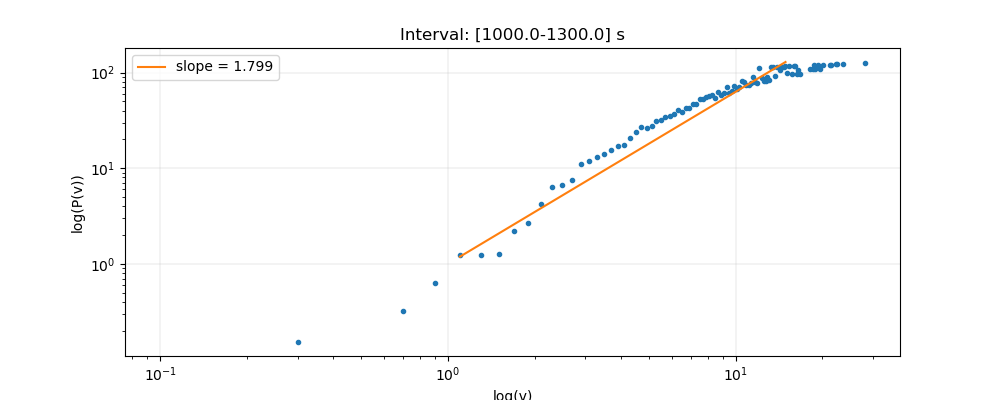

In [72]:
def expFunction2(x, b):
    return np.power(x, b)
    
v_distr_blue = np.zeros((nSteps, bin_centers.shape[0]))
v_distr_red = np.zeros((nSteps, bin_centers.shape[0]))
for k in range(nSteps):
    v_distr = np.histogram(v_blue_wind[k], bins = bin_borders, density = True)[0]
    v_distr_blue[k] = -(2*blue_fit_wind[k, 0]**2)*np.log((blue_fit_wind[k, 0]**2/bin_centers)*v_distr)

    v_distr = np.histogram(v_red_wind[k], bins = bin_borders, density = True)[0]
    v_distr_red[k] = -(2*red_fit_wind[k, 0]**2)*np.log((red_fit_wind[k, 0]**2/bin_centers)*v_distr)

step = 100
idx = np.isfinite(np.log(v_distr_blue[step]))
fit_range = (idx)  & (bin_centers > 1) & (bin_centers < 15)
popt, pcov = curve_fit(expFunction2, bin_centers[fit_range], v_distr_blue[step][fit_range])

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(bin_centers, v_distr_blue[step], '.')
ax.plot(bin_centers[fit_range], expFunction2(bin_centers[fit_range], *popt), label = f"slope = {round(popt[0], 3)}")
ax.set(title = f"Interval: [{startFrames[step]/fps}-{endFrames[step]/fps}] s", xscale="log", yscale="log", xlabel = "log(v)", ylabel = "log(P(v))")
ax.legend()
ax.grid(linewidth = 0.2)
plt.savefig(f"./{res_path}/speed_distribution/velocity_distribution_fit_example2.png", bbox_inches='tight')
plt.show()

/var/folders/8x/m08xmk_178vd007wy7lbx80w0000gn/T/ipykernel_50449/2597125798.py:5: RuntimeWarning: invalid value encountered in log
  idx = np.isfinite(np.log(v_distr_blue[step]))
/var/folders/8x/m08xmk_178vd007wy7lbx80w0000gn/T/ipykernel_50449/2597125798.py:11: RuntimeWarning: invalid value encountered in log
  idx = np.isfinite(np.log(v_distr_red[step]))


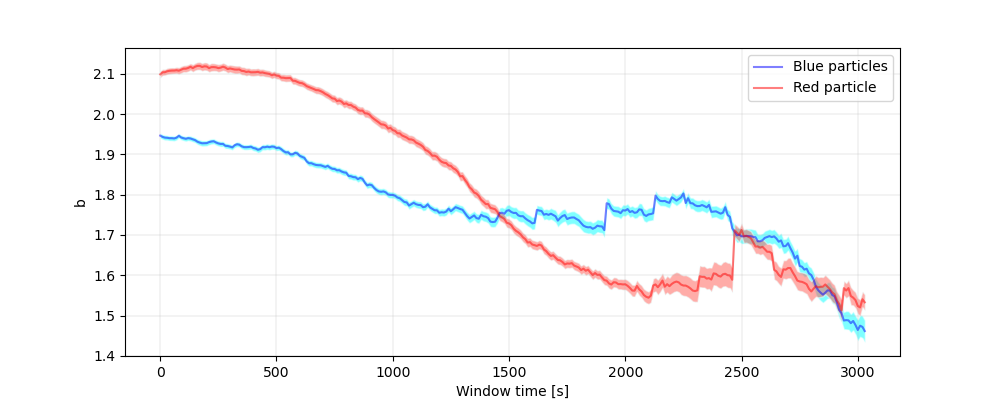

In [74]:
b_b = np.zeros((nSteps, 2))
b_r = np.zeros((nSteps, 2))

for step in np.arange(0,nSteps, 1):
    idx = np.isfinite(np.log(v_distr_blue[step]))
    fit_range = (idx) & (bin_centers > 1) & (bin_centers < 15) 
    popt, pcov = curve_fit(expFunction2, bin_centers[fit_range], v_distr_blue[step][fit_range])
    b_b[step, 0] = popt[0]
    b_b[step, 1] = np.sqrt(np.diag(pcov))[0]

    idx = np.isfinite(np.log(v_distr_red[step]))
    fit_range = (idx) & (bin_centers < 15) & (bin_centers > 3)
    popt, pcov = curve_fit(expFunction2, bin_centers[fit_range], v_distr_red[step][fit_range])
    b_r[step, 0] = popt[0]
    b_r[step, 1] = np.sqrt(np.diag(pcov))[0]

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(startFrames/fps, b_b[:, 0], 'b-', alpha = 0.5, label = 'Blue particles')
ax.fill_between(startFrames/fps, b_b[:, 0] - b_b[:, 1], b_b[:, 0] + b_b[:, 1], alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.plot(startFrames/fps, b_r[:, 0], 'r-', alpha = 0.5, label = 'Red particle ')
ax.fill_between(startFrames/fps, b_r[:, 0] - b_r[:, 1], b_r[:, 0] + b_r[:, 1], alpha=0.5, edgecolor='#F0FFFF', facecolor='#FF5A52')
plt.savefig(f"./{res_path}/speed_distribution/evolution_fit_example2.png", bbox_inches='tight')
ax.set(xlabel = "Window time [s]", ylabel = "b")
ax.legend()
ax.grid(linewidth = 0.2)
plt.show()

$$ \huge p(v) = \frac{v}{\sigma^2} e^{-\frac{v^\beta}{2\sigma^2}} $$

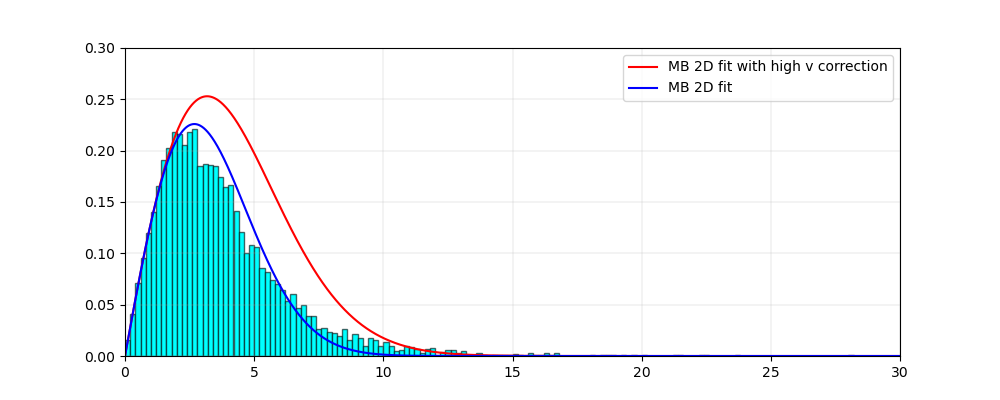

In [70]:
step = 100
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(v_blue_wind[step], bins = bin_borders, **default_kwargs_blue)
ax.plot(x_interval_for_fit, x_interval_for_fit/(blue_fit_wind[step, 0]**2) * np.exp(-x_interval_for_fit**b_b[step,0]/(2*blue_fit_wind[step, 0]**2)), 'r-', label = f"MB 2D fit with high v correction")
ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, blue_fit_wind[step, 0]), 'b-', label = f"MB 2D fit")
ax.legend()
ax.set(xlim = (0, 30), ylim = (0, 0.3))
ax.grid(linewidth = 0.2)
plt.show()

## trial of fit with Generalized 2D Maxwell-Boltzmann distribution
$$ \huge p(v) = \frac{v^\alpha}{\sigma^2} e^{-\frac{v^\beta}{2\sigma^2}} $$

In [96]:
# Generalized 2D Maxwell-Boltzmann distribution
def MB_2D_generalized(v, sigma, beta, alpha):
    return v**alpha/(sigma**2) * np.exp(-v**beta/(2*sigma**2))

test_blue = np.zeros((nSteps, 3))
test_blue_std = np.zeros((nSteps, 3))

test_red = np.zeros((nSteps, 3))
test_red_std = np.zeros((nSteps, 3))
for step in range(nSteps):
    test_blue[step], test_blue_std[step] = fit_hist(v_blue_wind[step], bin_borders, MB_2D_generalized, [1., 2., 1.])
    test_red[step], test_red_std[step] = fit_hist(v_red_wind[step], bin_borders, MB_2D_generalized, [1., 2., 1.])

step = 100
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(v_blue_wind[step], bins = bin_borders, **default_kwargs_blue)
ax.plot(x_interval_for_fit, MB_2D_generalized(x_interval_for_fit, *test_blue[step]), 'r-', label = f"Generalized MB 2D fit")
ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, blue_fit_wind[step, 0]), 'b-', label = f"MB 2D fit")
ax.legend()
ax.set(xlim = (0, 30), ylim = (0, 0.3), xlabel="speed [px/s]", ylabel="pdf", title = f"Confront at : [{startFrames[step]/fps}-{endFrames[step]/fps}] s")
ax.grid(linewidth = 0.2)
if save_verb: 
    plt.savefig(f"./{res_path}/speed_distribution/fit_generalized/generalized_MB_2D_fit_example.png", bbox_inches='tight')
    plt.savefig(f"./{pdf_res_path}/speed_distribution/generalized_MB_2D_fit_example.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

fig, (ax,ax1) = plt.subplots(2, 1, figsize=(10, 4))
ax.plot(startFrames/fps, test_blue[:, 1], 'b', label = "Blue particles")
ax.fill_between(startFrames/fps, test_blue[:, 1] - test_blue_std[:, 1], test_blue[:, 1] + test_blue_std[:, 1], alpha=0.5, facecolor='#00FFFF')
ax.plot(startFrames/fps, test_red[:, 1], 'r', label = "Red particle")
ax.fill_between(startFrames/fps, test_red[:, 1] - test_red_std[:, 1], test_red[:, 1] + test_red_std[:, 1], alpha=0.5, facecolor='#FF5A52')
ax.grid(linewidth = 0.2)
ax.legend()
ax.set(xlabel = "Window time [s]", ylabel = r"$\beta$", title = f"sigma of the fit of the velocity distribution - {system_name}")

ax1.plot(startFrames/fps, test_blue[:, 2], 'b', label = "Blue particles")
ax1.fill_between(startFrames/fps, test_blue[:, 2] - test_blue_std[:, 2], test_blue[:, 2] + test_blue_std[:, 2], alpha=0.5, facecolor='#00FFFF')
ax1.plot(startFrames/fps, test_red[:, 2], 'r', label = "Red particle")
ax1.fill_between(startFrames/fps, test_red[:, 2] - test_red_std[:, 2], test_red[:, 2] + test_red_std[:, 2], alpha=0.5, facecolor='#FF5A52')
ax1.grid(linewidth = 0.2)
ax1.legend()
ax1.set(xlabel = "Window time [s]", ylabel = r"$\alpha$")
if save_verb: 
    plt.savefig(f"./{res_path}/speed_distribution/fit_generalized/fit_results.png", bbox_inches='tight')
    plt.savefig(f"./{pdf_res_path}/speed_distribution/fit_results.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [90]:
# compute R2 for the fit of the speed distribution at each window
r2_blue_generalized = np.zeros(nSteps)
r2_red_generalized = np.zeros(nSteps)

for step in range(nSteps):
    y = np.histogram(v_blue_wind[step], bins = bin_borders, density = True)[0]
    y_fit = MB_2D_generalized(bin_centers, *test_blue[step])
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2_blue_generalized[step] = 1 - (ss_res / ss_tot)
    y = np.histogram(v_red_wind[step], bins = bin_borders, density = True)[0]
    y_fit = MB_2D_generalized(bin_centers,  *test_red[step])
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2_red_generalized[step] = 1 - (ss_res / ss_tot)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(startFrames/fps, r2_blue_generalized, 'b', label = "Blue particles")
ax.plot(startFrames/fps, r2_red_generalized, 'r', label = "Red particle")
ax.plot(startFrames/fps, r2_blue, 'b--', label = "MB 2D")
ax.plot(startFrames/fps, r2_red, 'r--', label = "MB 2D")
ax.grid(linewidth = 0.2)
ax.legend()
ax.set(xlabel = "time [s]", ylabel = "R2", title = f"R2 of the Generalized fit of the velocity distribution - {system_name}")
ax.set(ylim=(0.8, 1))
if save_verb: 
    plt.savefig(f"./{res_path}/speed_distribution/r2_generalized.png", bbox_inches='tight')
    plt.savefig(f"./{pdf_res_path}/speed_distribution/r2_generalized.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [82]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True


def prepare_animation(bar_container, bar_container2):
    def animate(frame):
        # update titles
        title.set_text(f"{system_name} - window {startFrames[frame]/fps} - {endFrames[frame]/fps} seconds - {system_name}")

        # update histogram 1
        n, _ = np.histogram(v_blue_wind[frame], bin_borders, density = True)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        
        line.set_ydata(MB_2D(x_interval_for_fit, blue_fit_wind[frame, 0]))

        line1.set_ydata(MB_2D_generalized(x_interval_for_fit, *test_blue[frame]))

        # update histogram 2
        n2, _ = np.histogram(v_red_wind[frame], bin_borders, density = True)
        for count2, rect2 in zip(n2, bar_container2.patches):
            rect2.set_height(count2)
            
        line2.set_ydata(MB_2D(x_interval_for_fit, red_fit_wind[frame, 0]))

        line3.set_ydata(MB_2D_generalized(x_interval_for_fit,  *test_red[frame]))
        

        return bar_container.patches, bar_container2.patches
    return animate

_, _, bar_container = ax.hist(v_blue_wind[0], bin_borders, **default_kwargs_blue, label="blue particles")
title = ax.set_title(f"{system_name} - window {startFrames[0]/fps} - {endFrames[0]/fps} seconds  - {system_name}")
line, = ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, blue_fit_wind[0, 0]), label='fit')
line1, = ax.plot(x_interval_for_fit, MB_2D_generalized(x_interval_for_fit,  *test_blue[0]), label='Generalized fit')
ax.set(xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.6))
ax.legend()

_, _, bar_container2 = ax1.hist(v_red_wind[0], bin_borders,  **default_kwargs_red, label="red particle")
#title2 = ax1.set_title(f"Red particle velocity pdf {startFrames[0]/fps} - {endFrames[0]/fps} seconds")
line2, = ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, red_fit_wind[0, 0]), label='fit')
line3, = ax1.plot(x_interval_for_fit, MB_2D_generalized(x_interval_for_fit,  *test_red[0]), label='Generalized fit')
ax1.set(xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.6))
ax1.legend()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
if save_verb: ani.save(f'./{res_path}/speed_distribution/speed_wind_confront.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if show_verb: 
    plt.show()
else:
    plt.close()

18:13:04 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
18:13:04 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ././25b_25r/results/speed_distribution/speed_wind_confront.mp4


# TURNING ANGLES DISTRIBUTIONS

In [ ]:
trajectories

In [ ]:
# choose the distribution to fit
distribution_str = "lorentzian"

if distribution_str == "gaussian":
    distribution = normal_distr
elif distribution_str == "lorentzian":
    distribution = lorentzian_distr
    distribution_str = "lorentzian"
else:
    raise ValueError("distribution_str must be either 'gaussian' or 'lorentzian'")
    
print(f"Turning Angles Analysis: show_verb = {show_verb}, animated_plot_verb = {animated_plot_verb}")
print("\n Global turning angles analysis")
blueTrajs, redTrajs = get_trajs(nDrops, red_particle_idx, trajectories)

bin_borders_turn = np.arange(-np.pi, np.pi + 0.0001, np.pi/50)
bin_centers_turn = bin_borders_turn[:-1] + np.diff(bin_borders_turn) / 2
x_interval_for_fit_turn = np.linspace(bin_borders_turn[0], bin_borders_turn[-1], 10000)

theta_blue = ys.turning_angles_ensemble(blueTrajs, centered = True)
theta_red  = ys.turning_angles_ensemble(redTrajs, centered = True)
# normal distribution fit
T_blue_rot, T_blue_rot_std = fit_hist(theta_blue, bin_borders_turn, distribution, [1., 0.])
T_red_rot, T_red_rot_std = fit_hist(theta_red, bin_borders_turn, distribution, [1., 0.])
print(f"Blue Particles σ: {T_blue_rot[0]} ± {T_blue_rot_std[0]}, μ: {T_blue_rot[1]} ± {T_blue_rot_std[1]}")
print(f"Red Particle σ: {T_red_rot[0]} ± {T_red_rot_std[0]}, μ: {T_red_rot[1]} ± {T_red_rot_std[1]}")

In [ ]:
if plot_verb:
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    ax.hist(theta_blue, bin_borders_turn, **default_kwargs_blue, label="blue particles")
    ax.plot(x_interval_for_fit_turn, distribution(x_interval_for_fit_turn, *T_blue_rot), 'k-',
                    label = f"$T = {T_blue_rot[0]:.2f} \pm {T_blue_rot_std[0]:.2f}$")
    ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
    ax.legend()
    ax.set_ylim(0, 3.5)

    ax1.hist(theta_red, bin_borders_turn, **default_kwargs_red, label="red particle")
    ax1.plot(x_interval_for_fit_turn, distribution(x_interval_for_fit_turn, *T_red_rot), 'k-',
                    label = f"$T = {T_red_rot[0]:.2f} \pm {T_red_rot_std[0]:.2f}$")
    ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
    ax1.legend()
    ax1.set_ylim(0, 3.5)
    plt.suptitle(f"Turning angles pdf - {system_name}")
    if 0: 
        plt.savefig(f"./{res_path}/turning_angles/{distribution_str}/turn_ang.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/turning_angles/{distribution_str}/turn_ang.pdf", bbox_inches='tight')
    if 1:
        plt.show()
    else:
        plt.close()

In [ ]:
print("\n Windowed turning angles analysis")
theta_blue_wind, theta_red_wind = theta_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajectories, fps)

blue_fit_wind_turn = np.ones((nSteps, 2, 2))
red_fit_wind_turn = np.ones((nSteps, 2, 2))
for k in range(nSteps):
    blue_fit_wind_turn[k, 0], blue_fit_wind_turn[k, 1] = fit_hist(theta_blue_wind[k], bin_borders_turn, distribution, [1., 0.])
    red_fit_wind_turn[k, 0], red_fit_wind_turn[k, 1] = fit_hist(theta_red_wind[k], bin_borders_turn, distribution, [1., 0.])

In [ ]:
    fig, ax = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
    ax.plot(startFrames/fps, blue_fit_wind_turn[:, 0, 0], 'b', label="blue particles")
    ax.fill_between(startFrames/fps, blue_fit_wind_turn[:, 0, 0] - blue_fit_wind_turn[:, 1, 0],
                    blue_fit_wind_turn[:, 0, 0] + blue_fit_wind_turn[:, 1, 0], color = 'b', alpha = 0.2)
    ax.set(ylabel = "T [??]", xlabel = "Window time [s]", title = f"Effective Temperature - {system_name}")

    ax.plot(startFrames/fps, red_fit_wind_turn[:, 0, 0], 'r', label = "Red particles")
    ax.fill_between(startFrames/fps, red_fit_wind_turn[:, 0, 0] - red_fit_wind_turn[:, 1, 0],
                        red_fit_wind_turn[:, 0, 0] + red_fit_wind_turn[:, 1, 0], color='r', alpha=0.2)
    ax.legend()
    ax.grid()
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f'./{res_path}/turning_angles/{distribution_str}/effective_T.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/turning_angles/{distribution_str}/effective_T.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

In [ ]:
if plot_verb: 
    fig, ax = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
    ax.plot(startFrames/fps, blue_fit_wind_turn[:, 0, 0], 'b', label="blue particles")
    ax.fill_between(startFrames/fps, blue_fit_wind_turn[:, 0, 0] - blue_fit_wind_turn[:, 1, 0],
                    blue_fit_wind_turn[:, 0, 0] + blue_fit_wind_turn[:, 1, 0], color = 'b', alpha = 0.2)
    ax.set(ylabel = "T [??]", xlabel = "Window time [s]", title = f"Effective Temperature - {system_name}")

    ax.plot(startFrames/fps, red_fit_wind_turn[:, 0, 0], 'r', label = "Red particles")
    ax.fill_between(startFrames/fps, red_fit_wind_turn[:, 0, 0] - red_fit_wind_turn[:, 1, 0],
                        red_fit_wind_turn[:, 0, 0] + red_fit_wind_turn[:, 1, 0], color='r', alpha=0.2)
    ax.legend()
    ax.grid()
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f'./{res_path}/turning_angles/{distribution_str}/effective_T.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/turning_angles/{distribution_str}/effective_T.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    ##############################################################################################################
    #                                              Animated Plots                                                #
    ##############################################################################################################
    if animated_plot_verb:
        
        fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def prepare_animation(bar_container, bar_container2):
            def animate(frame):
                title.set_text(f"Turning angles pdf - {system_name} - window {startFrames[frame]/fps} - {endFrames[frame]/fps} seconds - {system_name}")
                n, _ = np.histogram(theta_blue_wind[frame], bin_borders_turn, density = True)
                for count, rect in zip(n, bar_container.patches):
                    rect.set_height(count)
                line.set_ydata(distribution(x_interval_for_fit_turn, *blue_fit_wind_turn[frame, 0]))
                n2, _ = np.histogram(theta_red_wind[frame], bin_borders_turn, density = True)
                for count2, rect2 in zip(n2, bar_container2.patches):
                    rect2.set_height(count2)
                line1.set_ydata(distribution(x_interval_for_fit_turn, *red_fit_wind_turn[frame, 0]))
                return bar_container.patches, bar_container2.patches
            return animate
        _, _, bar_container = ax.hist(theta_red_wind[0], bin_borders_turn, **default_kwargs_blue, label="blue particles")
        line, = ax.plot(x_interval_for_fit_turn, distribution(x_interval_for_fit_turn, *blue_fit_wind_turn[0, 0]), label='fit')
        title = ax.set_title(f"Turning angles pdf - {system_name} - window {startFrames[0]/fps} - {endFrames[0]/fps} seconds - {system_name}")
        ax.set(ylabel = "pdf", ylim = (0, 3))
        ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
        _, _, bar_container2 = ax1.hist(theta_red_wind[0], bin_borders_turn,  **default_kwargs_red, label="red particle")
        line1, = ax1.plot(x_interval_for_fit_turn, distribution(x_interval_for_fit_turn, *red_fit_wind_turn[0, 0]), label='fit')
        ax1.set(ylabel = "pdf", ylim = (0, 3))
        ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
        plt.tight_layout()
        fig.canvas.mpl_connect('button_press_event', onClick)
        ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
        ani.save(f'./{res_path}/turning_angles/{distribution_str}/turn_ang_wind.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()

# VELOCITY AUTOCORRELATION

In [ ]:
show_verb = False
run_windowed_analysis = True
plot_verb = True
animated_plot_verb = True
save_verb = True
overwrite = False

In [ ]:
print(f"Velocity Autocorrelation Analysis: show_verb = {show_verb}, run_windowed_analysis = {run_windowed_analysis}, animated_plot_verb = {animated_plot_verb}")
print("Global Velocity Autocovariance Function")

blueTrajs, redTrajs = get_trajs(nDrops, red_particle_idx, trajectories)
vacf_b, vacf_std_b = ys.vacf(blueTrajs, time_avg=True, lag = maxLagtime)
vacf_r, vacf_std_r = ys.vacf(redTrajs, time_avg=True, lag = maxLagtime)

In [ ]:
if plot_verb:
    #Global Velocity Autocovariance
    fig, (ax, ax1) = plt.subplots(2, 1, figsize=(10, 5))
    ax.errorbar(np.arange(0, maxLagtime/fps, 1/fps), vacf_b, fmt='o', markersize = 1, color = "blue", label = 'blue particles')
    ax.fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_b + vacf_std_b, vacf_b - vacf_std_b, alpha=1, edgecolor='#F0FFFF', facecolor='#00FFFF')
    ax.grid()
    ax.legend()
    ax.set(xlim = (-1, 10), xlabel = 'Lag time [s]', ylabel = r'VACF [$(px/s)^2$]')
    ax1.errorbar(np.arange(0, maxLagtime/fps, 1/fps), vacf_r, fmt='o', markersize = 1, color = "red", label = 'red particles')
    ax1.fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_r + vacf_std_r, vacf_r - vacf_std_r, alpha=1, edgecolor='#FF0000', facecolor='#f44949')
    ax1.set(xlim = (-1, 10), xlabel = 'Lag time [s]', ylabel = r'VACF [$(px/s)^2$]')
    ax1.grid()
    ax1.legend()
    plt.suptitle(f"Velocity autocorrelation function - {system_name}")
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f"./{res_path}/velocity_autocovariance/vacf.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/velocity_autocovariance/vacf.pdf", bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()

In [ ]:
print("Windowed analysis")
if 0:
    vacf_b_wind, vacf_b_std_wind, vacf_r_wind, vacf_r_std_wind = vacf_windowed(trajectories)
else:
    vacf_b_wind     = pd.read_parquet(f"./{analysis_data_path}/velocity_autocovariance/vacf_b_wind.parquet")
    vacf_b_std_wind = pd.read_parquet(f"./{analysis_data_path}/velocity_autocovariance/vacf_b_std_wind.parquet")
    vacf_r_wind     = pd.read_parquet(f"./{analysis_data_path}/velocity_autocovariance/vacf_r_wind.parquet")
    vacf_r_std_wind = pd.read_parquet(f"./{analysis_data_path}/velocity_autocovariance/vacf_r_std_wind.parquet")

In [ ]:
if plot_verb:
    # Velocity Variance
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(startFrames/fps, vacf_b_wind["0"], 'b', label = "Blue particles")
    ax.plot(startFrames/fps, vacf_r_wind["0"], 'r', label = "Red particle")
    ax.set(title = f"Time evolution of velocity variance - {system_name}", ylabel = "$\sigma$", xlabel = "Window Time [s]")
    ax.grid()
    ax.legend()
    if save_verb: 
        plt.savefig(f"./{res_path}/velocity_autocovariance/vacf_wind_0.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/velocity_autocovariance/vacf_wind_0.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else: 
        plt.close()

    # Animated Plots
    if animated_plot_verb:
        fig = plt.figure(figsize=(8, 5))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def update_graph(step):
            line.set_ydata(vacf_b_wind.iloc[step]/vacf_b_wind.iloc[step]["0"])
            title.set_text(f"Velocity autocorrelation - {system_name} - window [{startFrames[step]/fps} - {endFrames[step]/fps}] s")
            line1.set_ydata(vacf_r_wind.iloc[step]/vacf_r_wind.iloc[step]["0"])
            return line, line1,
        ax = fig.add_subplot(211)
        title = ax.set_title(f"Velocity autocorrelation - {system_name} - window [{startFrames[0]/fps} - {endFrames[0]/fps}] s")
        line, = ax.plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind.iloc[0]/vacf_b_wind.iloc[0]["0"], 'b-', label = 'Blue particles')
        ax.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 20), ylim = (-0.5, 1.1))
        ax.grid()
        ax.legend()
        ax1 = fig.add_subplot(212)
        line1, = ax1.plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind.iloc[0]/vacf_r_wind.iloc[0]["0"], 'r-', label = 'Red particle')
        ax1.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 20), ylim = (-0.5, 1.1))
        ax1.grid()
        ax1.legend()
        plt.tight_layout()
        fig.canvas.mpl_connect('button_press_event', onClick)
        ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
        if save_verb: ani.save(f'./{res_path}/velocity_autocovariance/vacf_wind.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()

# RADIAL DISTRIBUTON FUNCTION

In [ ]:
print(f"RDF - {system_name} v2")
run_analysis_verb = False

n_red = len(red_particle_idx)
n_blue = nDrops - n_red
dr = trajectories.r.mean()
# center of petri dish --> to refine
r_c = [(xmax-xmin)+ xmin, (ymax-ymin)+ ymin]
rDisk = (xmax-xmin)/2
rList = np.arange(0, 2*rDisk, 1)
rho_b = n_blue/(np.pi*rDisk**2)
rho_r = n_red/(np.pi*rDisk**2) 
rho = nDrops/(np.pi*rDisk**2)

In [ ]:
if run_analysis_verb:
    rdf = get_rdf(frames, trajectories, red_particle_idx, rList, dr, rho_b, rho_r, n_blue, n_red)
    rdf_b  = rdf[:, 0, :]
    rdf_r  = rdf[:, 1, :]
    rdf_br = rdf[:, 2, :]
    rdf_rb = rdf[:, 3, :]
    rdf_b_df = pd.DataFrame(rdf_b)
    rdf_r_df = pd.DataFrame(rdf_r)
    rdf_br_df = pd.DataFrame(rdf_br)
    rdf_rb_df = pd.DataFrame(rdf_rb)
    # string columns for parquet filetype
    rdf_b_df.columns = [f"{r}" for r in rList]
    rdf_r_df.columns = [f"{r}" for r in rList]
    rdf_br_df.columns = [f"{r}" for r in rList]
    rdf_rb_df.columns = [f"{r}" for r in rList]
    rdf_b_df["frame"] = test_frames
    rdf_r_df["frame"] = test_frames
    rdf_br_df["frame"] = test_frames
    rdf_rb_df["frame"] = test_frames

    rdf_b_df.to_parquet(f"./{analysis_data_path}/rdf/rdf_b.parquet")
    rdf_r_df.to_parquet(f"./{analysis_data_path}/rdf/rdf_r.parquet")
    rdf_br_df.to_parquet(f"./{analysis_data_path}/rdf/rdf_br.parquet")
    rdf_rb_df.to_parquet(f"./{analysis_data_path}/rdf/rdf_rb.parquet")
elif not run_analysis_verb:
    try:
        rdf_b = np.array(pd.read_parquet(f"./{analysis_data_path}/rdf/rdf_b.parquet"))
        rdf_r = np.array(pd.read_parquet(f"./{analysis_data_path}/rdf/rdf_r.parquet"))
        rdf_br = np.array(pd.read_parquet(f"./{analysis_data_path}/rdf/rdf_br.parquet"))
        rdf_rb = np.array(pd.read_parquet(f"./{analysis_data_path}/rdf/rdf_rb.parquet"))
    except: 
        raise ValueError("rdf data not found. Run analysis verbosely first.")
else: 
    raise ValueError("run_analysis_verb must be True or False")

In [ ]:
if plot_verb:

    v_min = np.min([rdf_b, rdf_r, rdf_br, rdf_rb])
    v_max = np.max([rdf_b, rdf_r, rdf_br, rdf_rb])

    timearr = np.linspace(0, rdf_b.shape[0], 10)/fps
    timearr = timearr.astype(int)

    g_plot = rdf_b.T
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    img = ax.imshow(g_plot, vmin = v_min, vmax = v_max)
    ax.set(xticks = np.linspace(0, g_plot.shape[1], 10), yticks = np.linspace(0, g_plot.shape[0], 10))
    ax.set(xticklabels = timearr, yticklabels = np.linspace(0, 2*rDisk, 10).astype(int))
    ax.set(xlabel = "Time [s]", ylabel = "r [px]", title = "RDF b-b heatmap")
    fig.colorbar(img, ax=ax)
    ax.set_aspect('auto')
    if 1: 
        plt.savefig(f"./{res_path}/radial_distribution_function/rdf_heatmap_b.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/radial_distribution_function/rdf_heatmap_b.pdf", bbox_inches='tight')
    if 0: 
        plt.show()
    else:
        plt.close()


    g_plot = rdf_r.T
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    img = ax.imshow(g_plot, vmin = v_min, vmax = v_max)
    ax.set(xticks = np.linspace(0, g_plot.shape[1], 10), yticks = np.linspace(0, g_plot.shape[0], 10))
    ax.set(xticklabels = timearr, yticklabels = np.linspace(0, 2*rDisk, 10).astype(int))
    ax.set(xlabel = "Time [s]", ylabel = "r [px]", title = "RDF r-r heatmap")
    fig.colorbar(img, ax=ax)
    ax.set_aspect('auto')
    if 1: 
        plt.savefig(f"./{res_path}/radial_distribution_function/rdf_heatmap_r.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/radial_distribution_function/rdf_heatmap_r.pdf", bbox_inches='tight')
    if 0: 
        plt.show()
    else:
        plt.close()


    g_plot = rdf_br.T
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    img = ax.imshow(g_plot, vmin = v_min, vmax = v_max)
    ax.set(xticks = np.linspace(0, g_plot.shape[1], 10), yticks = np.linspace(0, g_plot.shape[0], 10))
    ax.set(xticklabels = timearr, yticklabels = np.linspace(0, 2*rDisk, 10).astype(int))
    ax.set(xlabel = "Time [s]", ylabel = "r [px]", title = "RDF b-r heatmap")
    fig.colorbar(img, ax=ax)
    ax.set_aspect('auto')
    if 1: 
        plt.savefig(f"./{res_path}/radial_distribution_function/rdf_heatmap_br.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/radial_distribution_function/rdf_heatmap_br.pdf", bbox_inches='tight')
    if 0: 
        plt.show()
    else:
        plt.close()


    g_plot = rdf_rb.T
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    img = ax.imshow(g_plot, vmin = v_min, vmax = v_max)
    ax.set(xticks = np.linspace(0, g_plot.shape[1], 10), yticks = np.linspace(0, g_plot.shape[0], 10))
    ax.set(xticklabels = timearr, yticklabels = np.linspace(0, 2*rDisk, 10).astype(int))
    ax.set(xlabel = "Time [s]", ylabel = "r [px]", title = "RDF r-b heatmap")
    fig.colorbar(img, ax=ax)
    ax.set_aspect('auto')
    if 1: 
        plt.savefig(f"./{res_path}/radial_distribution_function/rdf_heatmap_rb.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/radial_distribution_function/rdf_heatmap_rb.pdf", bbox_inches='tight')
    if 0: 
        plt.show()
    else:
        plt.close()

    
    if animated_plot_verb:
        # Animated plot for trajs results
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def animate(frame):
            line.set_ydata(rdf_b[frame])  # update the data.
            title.set_text(f'RDF b-b - {system_name} {int(frame/fps)} at s')
            return line, 

        line, = ax.plot(rList, rdf_b[0])
        title = ax.set_title(f'RDF b-b - {system_name} at 0 s')
        ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, rdf_b.shape[0], 10), interval=5, blit=False)
        ax.set(ylim = (-0.5, v_max), ylabel = "g(r)", xlabel = "r (px)")
        fig.canvas.mpl_connect('button_press_event', onClick)
        if save_verb: ani.save(f'./{res_path}/radial_distribution_function/rdf_b.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()

        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def animate(frame):
            line.set_ydata(rdf_r[frame])  # update the data.
            title.set_text(f'RDF r-r - {system_name} {int(frame/fps)} at s')
            return line, 

        line, = ax.plot(rList, rdf_r[0])
        title = ax.set_title(f'RDF r-r - {system_name} at 0 s')
        ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, rdf_r.shape[0], 10), interval=5, blit=False)
        ax.set(ylim = (-0.5, v_max), ylabel = "g(r)", xlabel = "r (px)")
        fig.canvas.mpl_connect('button_press_event', onClick)
        if save_verb: ani.save(f'./{res_path}/radial_distribution_function/rdf_r.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def animate(frame):
            line.set_ydata(rdf_br[frame])  # update the data.
            title.set_text(f'RDF b-r - {system_name} {int(frame/fps)} at s')
            return line, 

        line, = ax.plot(rList, rdf_b[0])
        title = ax.set_title(f'RDF b-r - {system_name} at 0 s')
        ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, rdf_br.shape[0], 10), interval=5, blit=False)
        ax.set(ylim = (-0.5, v_max), ylabel = "g(r)", xlabel = "r (px)")
        fig.canvas.mpl_connect('button_press_event', onClick)
        if save_verb: ani.save(f'./{res_path}/radial_distribution_function/rdf_br.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def animate(frame):
            line.set_ydata(rdf_rb[frame])  # update the data.
            title.set_text(f'RDF r-b - {system_name} {int(frame/fps)} at s')
            return line, 

        line, = ax.plot(rList, rdf_b[0])
        title = ax.set_title(f'RDF r-b - {system_name} at 0 s')
        ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, rdf_rb.shape[0], 10), interval=5, blit=False)
        ax.set(ylim = (-0.5, v_max), ylabel = "g(r)", xlabel = "r (px)")
        fig.canvas.mpl_connect('button_press_event', onClick)
        if save_verb: ani.save(f'./{res_path}/radial_distribution_function/rdf_rb.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()

In [ ]:
if run_analysis_verb:
    print(f"RDF from center - {system_name}")
    rdf_c = get_rdf_center(frames, trajectories, r_c, rList, dr, rho)
    print("Saving rdf_c")
    rdf_c_df = pd.DataFrame(rdf_c)
    # string columns for parquet filetype
    rdf_c_df.columns = [str(i) for i in rList]
    pd.DataFrame(rdf_c_df).to_parquet(f"./{analysis_data_path}/rdf/rdf_center.parquet")
if not run_analysis_verb :
    try: 
        rdf_c = np.array(pd.read_parquet(f"./{analysis_data_path}/rdf/rdf_center.parquet"))
    except: 
        raise ValueError("rdf data not found. Run analysis verbosely first.")

In [ ]:
if plot_verb:
    timearr = np.linspace(0, rdf_c.shape[0], 10)/fps
    timearr = timearr.astype(int)

    fig, ax = plt.subplots(1, 1, figsize = (10, 4))
    ax.plot(rList, rdf_c.mean(axis=0), label="mean")
    ax.fill_between(rList, rdf_c.mean(axis=0) - rdf_c.std(axis=0), \
                        rdf_c.mean(axis=0) + rdf_c.std(axis=0), alpha=0.3, label="std")
    ax.set(xlabel = "r [px]", ylabel = "g(r)", title = f"RDF from center - {system_name}")
    ax.legend()
    if save_verb: 
        plt.savefig(f"./{res_path}/radial_distribution_function/rdf_center.png", bbox_inches='tight' )
        plt.savefig(f"./{pdf_res_path}/radial_distribution_function/rdf_center.pdf", bbox_inches='tight' )
    if show_verb: 
        plt.show()
    else:
        plt.close()

    g_plot = rdf_c.T
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    img = ax.imshow(g_plot, vmin = 0, vmax = 10)
    ax.set(xticks = np.linspace(0, g_plot.shape[1], 10), yticks = np.linspace(0, g_plot.shape[0], 10))
    ax.set(xticklabels = timearr, yticklabels = np.linspace(0, rDisk, 10).astype(int))
    ax.set(xlabel = "Time [s]", ylabel = "r [px]", title = f"rdf from center heatmap - {system_name}")
    fig.colorbar(img, ax=ax)
    ax.set_aspect('auto')
    if save_verb: 
        plt.savefig(f"./{res_path}/radial_distribution_function/rdf_center_heatmap.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/radial_distribution_function/rdf_center_heatmap.pdf", bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()

    if animated_plot_verb:
        fig, ax = plt.subplots()
        anim_running = True

        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True

        line, = ax.plot(rList, rdf_c[0])
        title = ax.set_title(f'RDF from center - {system_name} 0 s')
        ax.set_ylim(-1, 15)

        def animate(frame):
            line.set_ydata(rdf_c[frame])  # update the data.
            title.set_text(f'RDF from center - {system_name} {int(frame/fps)} s')
            return line, 

        fig.canvas.mpl_connect('button_press_event', onClick)
        ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, nFrames, fps), interval = 5, blit=False)
        if save_verb: ani.save(f'./{res_path}/radial_distribution_function/rdf_from_center.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()

# 3 BODY STRUCTURE METRIC